# Project 3: Web APIs & Classification 

## Problem Statement

What is the **best classification model** that is able to identify whether a post belongs to the r/science subreddit or the r/nature subreddit with **at least 80% accuracy** and what are the **top 5 features**?

## Executive Summary

The objective of this project is to create the best classification model to identify Reddit posts, with the goals as stated in the problem statement. For this project, the data has to be gathered manually using Reddit API.

For the training data set, a total of 625 posts were gathered from the r/science subreddit and 550 posts from the r/nature subreddit. As usable language data can both be found in the post title and post content, they were merged to create new variable. For the purpose of this project, models comprising of combinations of the following are considered:

    - Pre-processing: 1) Lemmatization       2) PorterStemmer
    - Transformer:    1) Count Vectorizer    2) TF-IDF Vectorizer
    - Model:          1) Logistic Regression 2) Naive Bayes MultinomialNB

After assessing the various models, the model comprising of Lemmatization -> TF-IDF Vectorizer -> Naive Bayes MultinomialNB is found to be the most suitable model which fits our objectives. The top 5 features are 1) study 2) covid 3) new 4) researcher 5) people. After testing the selected model on data that were extracted separately, the model is still able to perform up to targeted levels.

Some recommendations to further improve the model include:
    
- Gather training data over a longer period of time to avoid time-period sensitive terms such as covid
- Use alternative scoring such as lowest drop in score between training and testing data to select best model during GridSearch

## Sections

- [Import libraries](#Import-libraries)
- [Data Collection](#Data-Collection)
- [Data Cleaning and Exploratory Data Analysis](#Data-Cleaning-and-Exploratory-Data-Analysis)
- [Baseline Model](#Baseline-Model)
- [Lemmatize and test multiple models](#Lemmatize-and-test-multiple-models)
    - [Count Vectorizer with Logistic Regression](#Use-CountVectorizer-on-lemmatized-words-and-model-with-Logistic-Regression)
    - [Count Vectorizer with Naive Bayes MultinomialNB](#Use-CountVectorizer-on-lemmatized-words-and-model-with-Naive-Bayes)
    - [TF-IDF Vectorizer with Logistic Regression](#Use-TF-IDF-Vectorizer-on-lemmatized-words-and-model-with-Logistic-Regression)
    - [TF-IDF Vectorizer with Naive Bayes MultinomialNB](#Use-TF-IDF-Vectorizer-on-lemmatized-words-and-model-with-Naive-Bayes)
- [Stem and test multiple models](#Stem-and-test-multiple-models)
    - [Count Vectorizer with Logistic Regression](#Use-CountVectorizer-on-stemmed-words-and-model-with-Logistic-Regression)
    - [Count Vectorizer with Naive Bayes MultinomialNB](#Use-CountVectorizer-on-stemmed-words-and-model-with-Naive-Bayes)
    - [TF-IDF Vectorizer with Logistic Regression](#Use-TF-IDF-Vectorizer-on-stemmed-words-and-model-with-Logistic-Regression)
    - [TF-IDF Vectorizer with Naive Bayes MultinomialNB](#Use-TF-IDF-Vectorizer-on-stemmed-words-and-model-with-Naive-Bayes)
- [Model Evaluation and Selection](#Model-Evaluation-and-Selection)
- [Test Selected Model on Unseen Data](#Test-Selected-Model-on-Unseen-Data)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)


## Import libraries

In [1]:
# Import libraries

import requests
import time
import random
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\junyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Collection

In [3]:
# Define subreddits
subreddit_1 = 'science'
subreddit_2 = 'nature'

In [4]:
# Define list of urls to pull data from
url_list = [f'https://www.reddit.com/r/{subreddit_1}.json',
            f'https://www.reddit.com/r/{subreddit_2}.json']

In [5]:
# Define function to extract posts from the two subreddits and save into csv file
def get_posts(url_list, num_pages, save_name = 'train', set_after = None):
    
    keys = ['subreddit', 'name', 'title','selftext']
    posts = []
    for i in range(len(url_list)):    
        
        if set_after == None:
            after = None
        else:
            after = set_after
            
        for a in range(num_pages):
            if after == None:
                current_url = url_list[i]
            else:
                current_url = url_list[i] + '?after=' + after
            print(f'Requesting from page {a+1}:{current_url}.')
            res = requests.get(current_url, headers={'User-agent': 'Hobo Inc 1.0'})

            if res.status_code != 200:
                print('Status error', res.status_code)
                break

            current_dict = res.json()
            current_posts = [{key : current_dict['data']['children'][i]['data'][key] for key in keys} for i in range(len(current_dict['data']['children']))]
            
            after = current_dict['data']['after']
            
            if after == None:
                print('All posts in subreddit extracted.')
                break
            else:
                print(after)
            
            if set_after != None:
                prev_posts = pd.read_csv(f'./datasets/{save_name}.csv')
                current_df = pd.DataFrame(current_posts)
                prev_posts.append(current_df).to_csv(f'./datasets/{save_name}.csv', index = False)
                print(f'Data till {current_url} saved.')
            else:
                posts.extend(current_posts)
                pd.DataFrame(posts).to_csv(f'./datasets/{save_name}.csv', index = False)
                print(f'Data till {current_url} saved.')
            
            if a != (num_pages - 1):
            # generate a random sleep duration to look more 'natural'
                sleep_duration = random.randint(2,6)
                time.sleep(sleep_duration)
    

    print('Data acquisition completed.')

In [6]:
# Get 50 pages from each subreddit, if available

# get_posts(url_list, 50)

In [7]:
# Run this if data extraction is interrupted
# Note: - Can only run one subreddit at a time. - Need to define last ['after']

# get_posts(['https://www.reddit.com/r/boardgames.json'], 1, set_after='t3_gemav6')

## Data Cleaning and Exploratory Data Analysis

In [8]:
# Read train.csv
df_train = pd.read_csv('./datasets/train.csv')

In [9]:
# Fill null entries with ''
df_train.fillna('', inplace=True)

In [10]:
# Check for duplicates
df_train.duplicated(subset=['name']).value_counts()

False    1175
dtype: int64

In [11]:
# Create new column which combines both title and selftext
df_train['post'] = df_train['title'] + ' ' + df_train['selftext']

In [12]:
# Drop extra columns
df_train.drop(columns=['name','title','selftext'], axis=1, inplace=True)

In [13]:
# Encode subreddit column
df_train['subreddit'] = df_train['subreddit'].map({subreddit_1:1, subreddit_2:0})

In [14]:
df_train.head()

,subreddit,post
0,1,Study finds Intolerable bouts of extreme humid...
1,1,Police stop fewer black drivers at night when ...
2,1,"Canadian study finds temperature, latitude not..."
3,1,Mere exposure to refugees in Germany increased...
4,1,Hyperinflammatory shock in children during COV...


In [15]:
# Check number of posts from each subreddit
df_train['subreddit'].value_counts()

1    625
0    550
Name: subreddit, dtype: int64

In [16]:
df_train.shape

(1175, 2)

##  Baseline Model

In [17]:
df_train['subreddit'].value_counts(normalize=True)

1    0.531915
0    0.468085
Name: subreddit, dtype: float64

**Comment**

The baseline model predicts that a post has approximately 53 percent probability of being from the r/science subreddit and approximately 47 percent from the r/nature subreddit.

##  Lemmatize and test multiple models

In [18]:
# Initialise Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert a post to a string of words using Lemmatizer
def clean_postl(post):
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(post).get_text()
    post_text = re.sub(r"http\S+", "", post_text)
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Gather stopwords
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Lemmatize the words
    meaningful_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [19]:
# Define function that generates a Wordcloud
def gen_cloud (df):
    df = df.transpose()
    df['sum'] = df.sum(axis=1)
    word_bag = df[['sum']]
    word_bag.reset_index(inplace=True)

    word_dict = {}
    for a, x in word_bag.values:
        word_dict[a] = x
    wordcloud = WordCloud(width=1200, height=900, background_color='white',min_font_size=10)
    wordcloud.generate_from_frequencies(word_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

---

In [20]:
# Run function that preprocess and lemmatize posts
df_trainl = df_train.copy()
for i in range(len(df_trainl['post'])):
    df_trainl.iloc[i,1] = clean_postl(df_trainl.iloc[i,1])

In [21]:
df_trainl.head()

,subreddit,post
0,1,study find intolerable bout extreme humidity h...
1,1,police stop fewer black driver night veil dark...
2,1,canadian study find temperature latitude assoc...
3,1,mere exposure refugee germany increased vote f...
4,1,hyperinflammatory shock child covid pandemic


In [22]:
# Define X and y
X = df_trainl['post']
y = df_trainl['subreddit']

In [23]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state=42,
                                                   stratify=y)

In [24]:
# Define class that merges Pipeline and GridSearch and generate summaries and graphs
class pipe_model:
    def __init__(self, steps, params):
        self.steps = steps
        self.params = params
        
        self.pipe_GS = GridSearchCV(Pipeline(self.steps),
                              self.params,
                              cv=5)
        self.pipe_GS.fit(X_train,y_train)
        
        self.best_score = round(self.pipe_GS.best_score_,4)
        self.train_score = round(self.pipe_GS.best_estimator_.score(X_train,y_train),4)
        self.test_score = round(self.pipe_GS.best_estimator_.score(X_test,y_test),4)
        
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(y_test,self.pipe_GS.best_estimator_.predict(X_test)).ravel()
        
        pred_proba = [i[1] for i in self.pipe_GS.best_estimator_.predict_proba(X_test)]
        self.pred_df = pd.DataFrame({'true_values' : y_test,
                                     'pred_probs' : pred_proba})
        
    def summary(self):
        print('GridSearch best score: '.rjust(40) + f'{self.best_score}')
        print('Score on train data: '.rjust(40) + f'{self.train_score}')
        print('Score on test data: '.rjust(40) + f'{self.test_score}')
        print('Score change from train to test data: '.rjust(40) + f'{round(self.test_score - self.train_score,4)}')
        print('')
        print('True Negatives: '.rjust(40) + f'{self.tn}')
        print('False Positives: '.rjust(40) + f'{self.fp}')
        print('False Negatives: '.rjust(40) + f'{self.fn}')
        print('True Positives: '.rjust(40) + f'{self.tp}')
        print('')
        print('Accuracy: '.rjust(40) + f'{round((self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn),2)}')
        print('Sensitivity: '.rjust(40) + f'{round((self.tp) / (self.tp + self.fn),2)}')
        print('Specificity: '.rjust(40) + f'{round((self.tn) / (self.fp + self.tn),2)}')
        print('Precision: '.rjust(40) + f'{round((self.tp) / (self.tp + self.fp),2)}')
        
    def gen_wordcloud(self):
        transfomer = self.pipe_GS.best_estimator_.named_steps[self.steps[0][0]]

        X_train_features = transfomer.fit_transform(X_train)
        X_train_df = pd.DataFrame(X_train_features.toarray(), columns=transfomer.get_feature_names())
        gen_cloud(X_train_df)
    
    def get_log_features(self):
        transfomer = self.pipe_GS.best_estimator_.named_steps[self.steps[0][0]]
        df_features = pd.DataFrame({'features' : transfomer.get_feature_names(),
                                    'odds' :np.exp(self.pipe_GS.best_estimator_.named_steps[self.steps[1][0]].coef_[0])})
        print('Top 5 words for Y = 1')
        print(df_features.sort_values('odds',ascending=False).head())
        print('')
        print('Lowest 5 words for Y = 1')
        print(df_features.sort_values('odds').head())
        
    def get_nb_features(self):
        transfomer = self.pipe_GS.best_estimator_.named_steps[self.steps[0][0]]
        df_features = pd.DataFrame({'features' : transfomer.get_feature_names(),
                                    'Log Probability' : self.pipe_GS.best_estimator_.named_steps[self.steps[1][0]].feature_log_prob_[1]})
        print('Top 5 words for Y = 1')
        print(df_features.sort_values('Log Probability',ascending=False).head())
        print('')
        print('Lowest 5 words for Y = 1')
        print(df_features.sort_values('Log Probability').head())
        
    def gen_roc_auc(self):
        # Create figure.
        plt.figure(figsize = (10,7))

        # Create threshold values. (Dashed red line in image.)
        thresholds = np.linspace(0, 1, 200)

        # Define function to calculate sensitivity. (True positive rate.)
        def TPR(df, true_col, pred_prob_col, threshold):
            true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
            false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
            return true_positive / (true_positive + false_negative)


        # Define function to calculate 1 - specificity. (False positive rate.)
        def FPR(df, true_col, pred_prob_col, threshold):
            true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
            false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
            return 1 - (true_negative / (true_negative + false_positive))

        # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
        tpr_values = [TPR(self.pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
        fpr_values = [FPR(self.pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

        # Plot ROC curve.
        plt.plot(fpr_values, # False Positive Rate on X-axis
                 tpr_values, # True Positive Rate on Y-axis
                 label='ROC Curve')

        # Plot baseline. (Perfect overlap between the two populations.)
        plt.plot(np.linspace(0, 1, 200),
                 np.linspace(0, 1, 200),
                 label='baseline',
                 linestyle='--')

        # Label axes.
        plt.title(f'ROC Curve with AUC = {round(roc_auc_score(self.pred_df["true_values"],self.pred_df["pred_probs"]),3)}', fontsize=22)
        
        plt.ylabel('Sensitivity', fontsize=18)
        plt.xlabel('1 - Specificity', fontsize=18)

        # Create legend.
        plt.legend(fontsize=16);
    
    def add_to_results(self, df, preprocessor):
        
        df.loc[len(df)] = [preprocessor, self.steps[0][0], self.steps[1][0], 
                            round(roc_auc_score(self.pred_df["true_values"],self.pred_df["pred_probs"]),3),
                            self.train_score, self.test_score, round(self.test_score - self.train_score,4),
                            round((self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn),2),
                            round((self.tp) / (self.tp + self.fn),2), round((self.tn) / (self.fp + self.tn),2),
                            round((self.tp) / (self.tp + self.fp),2)]

In [25]:
# Define dataframe that will capture the output of every model
df_results = pd.DataFrame(columns=['Pre_processing', 'Transformer', 'Model', 'ROC_AUC_score',
                                   'Train_data_score', 'Test_data_score', 'Score_change',
                                   'Accuracy', 'Sensitivity','Specificity','Precision'])

### Use CountVectorizer on lemmatized words and model with Logistic Regression

In [26]:
# Define steps and parameters
steps_cv_lr_l = [
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
]

params_cv_lr_l = {
    'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'logr__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'logr__max_iter' : [1000]
}

In [27]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_cv_lr_l = pipe_model(steps_cv_lr_l,params_cv_lr_l)

In [28]:
# Generate summary
pipe_cv_lr_l.summary()

                 GridSearch best score: 0.8536
                   Score on train data: 0.9898
                    Score on test data: 0.8265
  Score change from train to test data: -0.1633

                        True Negatives: 114
                       False Positives: 24
                       False Negatives: 27
                        True Positives: 129

                              Accuracy: 0.83
                           Sensitivity: 0.83
                           Specificity: 0.83
                             Precision: 0.84


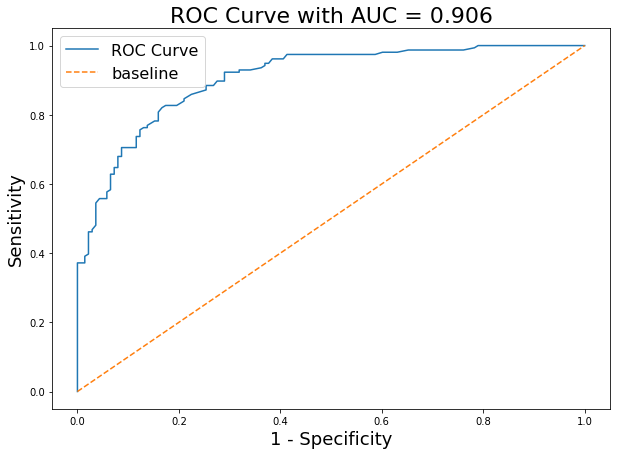

In [29]:
# Generate ROC Curve with AUC score
pipe_cv_lr_l.gen_roc_auc()

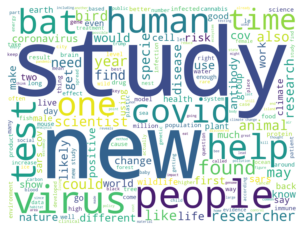

In [30]:
# Generate WordCloud
pipe_cv_lr_l.gen_wordcloud()

In [31]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_cv_lr_l.get_log_features()

Top 5 words for Y = 1
        features      odds
321        covid  4.676972
601       fossil  3.290594
1209     quantum  3.044632
1195     protein  2.935167
96    atmosphere  2.910497

Lowest 5 words for Y = 1
      features      odds
1940  wildlife  0.204666
999     nature  0.303560
581       fish  0.336470
126       bear  0.377134
149       bird  0.384716


In [32]:
# Add results to results DataFrame
pipe_cv_lr_l.add_to_results(df_results, 'lemma')

### Use CountVectorizer on lemmatized words and model with Naive Bayes

In [33]:
# Define steps and parameters
steps_cv_nb_l = [
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
]

params_cv_nb_l = {
    'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha' : np.linspace(0.5, 1.5, 6),
    'nb__fit_prior' : [True, False]
}

In [34]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_cv_nb_l = pipe_model(steps_cv_nb_l,params_cv_nb_l)

In [35]:
# Generate summary
pipe_cv_nb_l.summary()

                 GridSearch best score: 0.8706
                   Score on train data: 0.9648
                    Score on test data: 0.8401
  Score change from train to test data: -0.1247

                        True Negatives: 109
                       False Positives: 29
                       False Negatives: 18
                        True Positives: 138

                              Accuracy: 0.84
                           Sensitivity: 0.88
                           Specificity: 0.79
                             Precision: 0.83


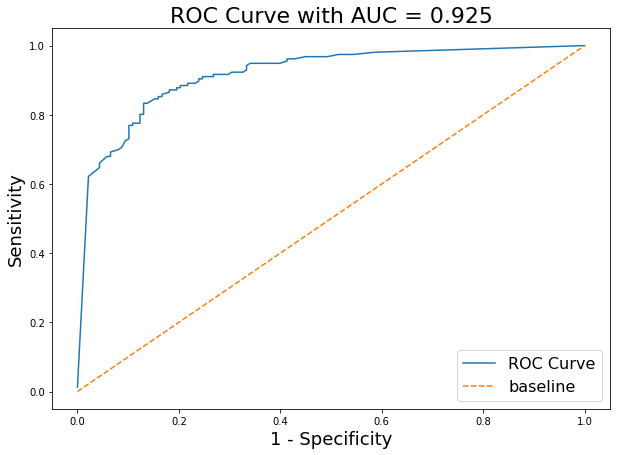

In [36]:
# Generate ROC Curve with AUC score
pipe_cv_nb_l.gen_roc_auc()

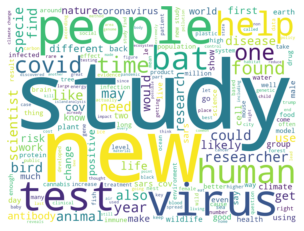

In [37]:
# Generate WordCloud
pipe_cv_nb_l.gen_wordcloud()

In [38]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_cv_nb_l.get_nb_features()

Top 5 words for Y = 1
     features  Log Probability
2369    study        -4.729438
2637    virus        -4.956211
1780   people        -4.980752
2466     test        -5.071724
1633      new        -5.085423

Lowest 5 words for Y = 1
           features  Log Probability
0         abandoned       -10.062157
1159          horse       -10.062157
1167  house sparrow       -10.062157
1182         humane       -10.062157
1183       humpback       -10.062157


In [39]:
# Add results to results DataFrame
pipe_cv_nb_l.add_to_results(df_results, 'lemma')

### Use TF-IDF Vectorizer on lemmatized words and model with Logistic Regression

In [40]:
# Define steps and parameters
steps_tv_lr_l = [
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())
]

params_tv_lr_l = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'logr__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'logr__max_iter' : [1000]
}

In [41]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_tv_lr_l = pipe_model(steps_tv_lr_l,params_tv_lr_l)

In [42]:
# Generate summary
pipe_tv_lr_l.summary()

                 GridSearch best score: 0.8513
                   Score on train data: 1.0
                    Score on test data: 0.8163
  Score change from train to test data: -0.1837

                        True Negatives: 105
                       False Positives: 33
                       False Negatives: 21
                        True Positives: 135

                              Accuracy: 0.82
                           Sensitivity: 0.87
                           Specificity: 0.76
                             Precision: 0.8


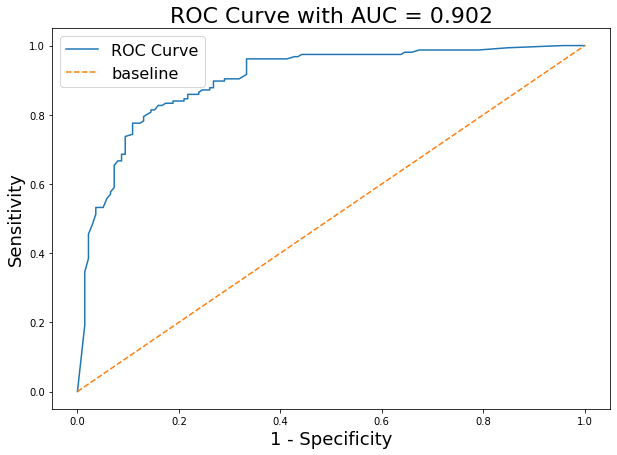

In [43]:
# Generate ROC Curve with AUC score
pipe_tv_lr_l.gen_roc_auc()

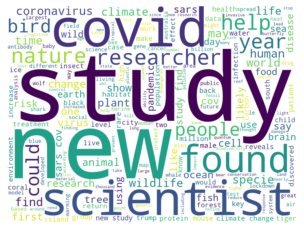

In [44]:
# Generate WordCloud
pipe_tv_lr_l.gen_wordcloud()

In [45]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_tv_lr_l.get_log_features()

Top 5 words for Y = 1
         features         odds
953        fossil  1498.199581
557         covid   655.303638
2063   researcher   615.419529
1002         gene   397.374622
1011  genetically   242.968963

Lowest 5 words for Y = 1
      features      odds
2695  wildlife  0.000222
1609    nature  0.000395
917       fish  0.001272
218       bear  0.002000
2176    secret  0.003993


In [46]:
# Add results to results DataFrame
pipe_tv_lr_l.add_to_results(df_results, 'lemma')

### Use TF-IDF Vectorizer on lemmatized words and model with Naive Bayes

In [47]:
# Define steps and parameters
steps_tv_nb_l = [
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
]

params_tv_nb_l = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha' : np.linspace(0.5, 1.5, 6),
    'nb__fit_prior' : [True, False]
}

In [48]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_tv_nb_l = pipe_model(steps_tv_nb_l,params_tv_nb_l)

In [49]:
# Generate summary
pipe_tv_nb_l.summary()

                 GridSearch best score: 0.8706
                   Score on train data: 0.9716
                    Score on test data: 0.8639
  Score change from train to test data: -0.1077

                        True Negatives: 114
                       False Positives: 24
                       False Negatives: 16
                        True Positives: 140

                              Accuracy: 0.86
                           Sensitivity: 0.9
                           Specificity: 0.83
                             Precision: 0.85


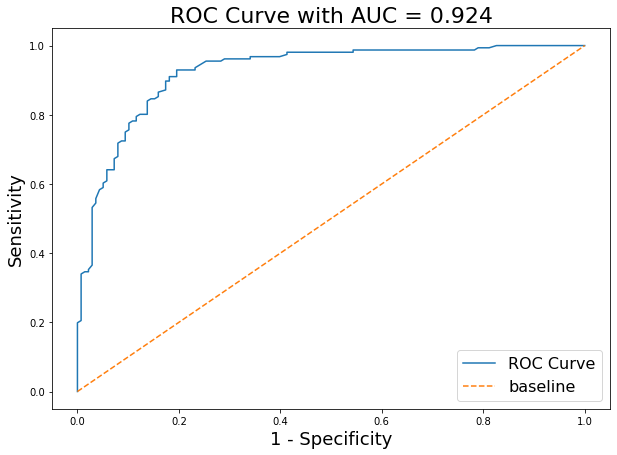

In [50]:
# Generate ROC Curve with AUC score
pipe_tv_nb_l.gen_roc_auc()

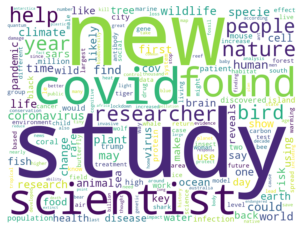

In [51]:
# Generate WordCloud
pipe_tv_nb_l.gen_wordcloud()

In [52]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_tv_nb_l.get_nb_features()

Top 5 words for Y = 1
        features  Log Probability
1693       study        -5.321794
443        covid        -5.437965
1175         new        -5.649251
1451  researcher        -5.795912
1277      people        -5.861720

Lowest 5 words for Y = 1
       features  Log Probability
0     abandoned         -8.33192
1575     shrimp         -8.33192
392    conflict         -8.33192
1581   sighting         -8.33192
1601        sky         -8.33192


In [53]:
# Add results to results DataFrame
pipe_tv_nb_l.add_to_results(df_results, 'lemma')

## Stem and test multiple models

In [54]:
# Initialise PorterStemmer
p_stemmer = PorterStemmer()

 # Function to convert a post to a string of words using PorterStemmer
def clean_postp(post):
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(post).get_text()
    post_text = re.sub(r"http\S+", "", post_text)
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Gather stopwords
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stem the words
    meaningful_words = [p_stemmer.stem(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [55]:
# Run function that preprocess and stems posts
df_trainp = df_train.copy()
for i in range(len(df_trainp['post'])):
    df_trainp.iloc[i,1] = clean_postp(df_trainp.iloc[i,1])

In [56]:
df_trainp.head()

,subreddit,post
0,1,studi find intoler bout extrem humid heat coul...
1,1,polic stop fewer black driver night veil dark ...
2,1,canadian studi find temperatur latitud associ ...
3,1,mere exposur refuge germani increas vote far r...
4,1,hyperinflammatori shock children covid pandem


In [57]:
# Define X and y
X = df_trainp['post']
y = df_trainp['subreddit']

In [58]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state=42,
                                                   stratify=y)

### Use CountVectorizer on stemmed words and model with Logistic Regression

In [59]:
# Define steps and parameters
steps_cv_lr_s = [
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
]

params_cv_lr_s = {
    'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'logr__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'logr__max_iter' : [1000]
}

In [60]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_cv_lr_s = pipe_model(steps_cv_lr_s,params_cv_lr_s)

In [61]:
# Generate summary
pipe_cv_lr_s.summary()

                 GridSearch best score: 0.8422
                   Score on train data: 1.0
                    Score on test data: 0.8095
  Score change from train to test data: -0.1905

                        True Negatives: 110
                       False Positives: 28
                       False Negatives: 28
                        True Positives: 128

                              Accuracy: 0.81
                           Sensitivity: 0.82
                           Specificity: 0.8
                             Precision: 0.82


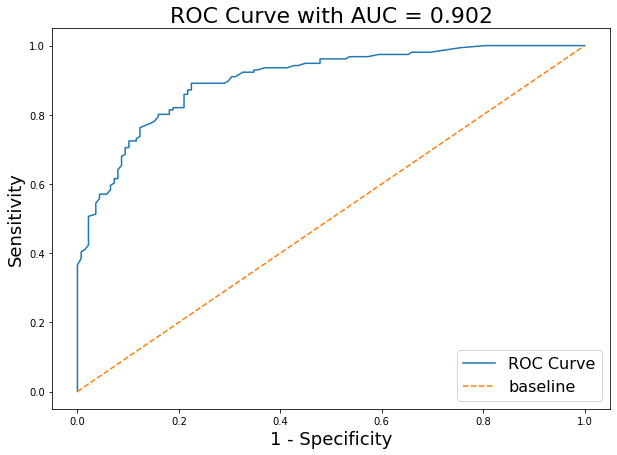

In [62]:
# Generate ROC Curve with AUC score
pipe_cv_lr_s.gen_roc_auc()

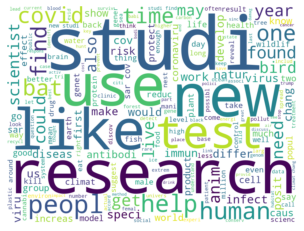

In [63]:
# Generate WordCloud
pipe_cv_lr_s.gen_wordcloud()

In [64]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_cv_lr_s.get_log_features()

Top 5 words for Y = 1
       features       odds
168   atmospher  17.707961
945      fossil  14.823351
546       covid  11.780766
2638  wikipedia  10.624585
754      effect   9.063389

Lowest 5 words for Y = 1
     features      odds
2643  wildlif  0.079151
2130   secret  0.113756
216      bear  0.117350
913      fish  0.144715
1270    invas  0.187073


In [65]:
# Add results to results DataFrame
pipe_cv_lr_s.add_to_results(df_results, 'stem')

### Use CountVectorizer on stemmed words and model with Naive Bayes

In [66]:
# Define steps and parameters
steps_cv_nb_s = [
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
]

params_cv_nb_s = {
    'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha' : np.linspace(0.5, 1.5, 6),
    'nb__fit_prior' : [True, False]
}

In [67]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_cv_nb_s = pipe_model(steps_cv_nb_s,params_cv_nb_s)

In [68]:
# Generate summary
pipe_cv_nb_s.summary()

                 GridSearch best score: 0.8683
                   Score on train data: 0.958
                    Score on test data: 0.8401
  Score change from train to test data: -0.1179

                        True Negatives: 106
                       False Positives: 32
                       False Negatives: 15
                        True Positives: 141

                              Accuracy: 0.84
                           Sensitivity: 0.9
                           Specificity: 0.77
                             Precision: 0.82


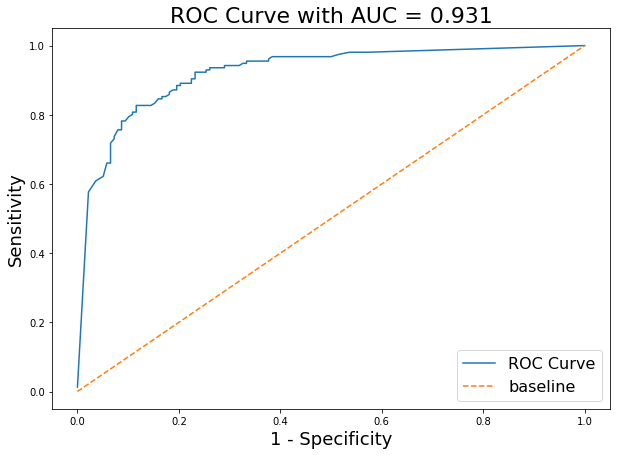

In [69]:
# Generate ROC Curve with AUC score
pipe_cv_nb_s.gen_roc_auc()

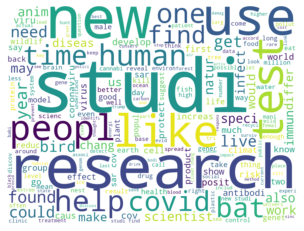

In [70]:
# Generate WordCloud
pipe_cv_nb_s.gen_wordcloud()

In [71]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_cv_nb_s.get_nb_features()

Top 5 words for Y = 1
      features  Log Probability
1682     studi        -4.613121
1780      test        -4.757602
1437  research        -4.778545
1870       use        -4.855506
1282     peopl        -4.938888

Lowest 5 words for Y = 1
      features  Log Probability
0      abandon       -10.020292
952  know mani       -10.020292
948       king       -10.020292
929      invas       -10.020292
896     incred       -10.020292


In [72]:
# Add results to results DataFrame
pipe_cv_nb_s.add_to_results(df_results, 'stem')

### Use TF-IDF Vectorizer on stemmed words and model with Logistic Regression

In [73]:
# Define steps and parameters
steps_tv_lr_s = [
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())
]

params_tv_lr_s = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'logr__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'logr__max_iter' : [1000]
}

In [74]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_tv_lr_s = pipe_model(steps_tv_lr_s,params_tv_lr_s)

In [75]:
# Generate summary
pipe_tv_lr_s.summary()

                 GridSearch best score: 0.866
                   Score on train data: 0.9977
                    Score on test data: 0.8401
  Score change from train to test data: -0.1576

                        True Negatives: 104
                       False Positives: 34
                       False Negatives: 13
                        True Positives: 143

                              Accuracy: 0.84
                           Sensitivity: 0.92
                           Specificity: 0.75
                             Precision: 0.81


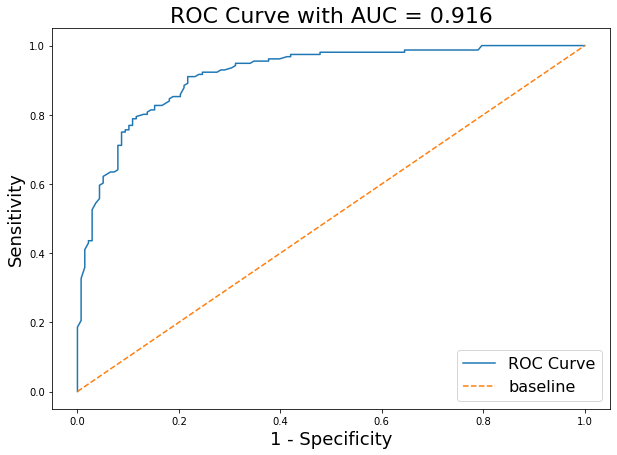

In [76]:
# Generate ROC Curve with AUC score
pipe_tv_lr_s.gen_roc_auc()

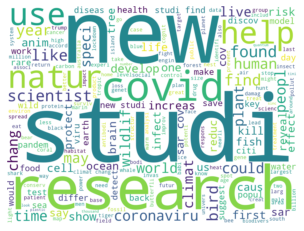

In [77]:
# Generate WordCloud
pipe_tv_lr_s.gen_wordcloud()

In [78]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_tv_lr_s.get_log_features()

Top 5 words for Y = 1
       features       odds
546       covid  64.363157
945      fossil  27.637823
168   atmospher  24.129567
1216    increas  21.824561
2008   research  18.211648

Lowest 5 words for Y = 1
     features      odds
2643  wildlif  0.008286
913      fish  0.021882
252      bird  0.032153
216      bear  0.032277
2639     wild  0.052993


In [79]:
# Add results to results DataFrame
pipe_tv_lr_s.add_to_results(df_results, 'stem')

### Use TF-IDF Vectorizer on stemmed words and model with Naive Bayes

In [80]:
# Define steps and parameters
steps_tv_nb_s = [
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
]

params_tv_nb_s = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.9, 0.95, 1.0],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha' : np.linspace(0.5, 1.5, 6),
    'nb__fit_prior' : [True, False]
}

In [81]:
# Instantiate pipe_model class. Note: this step will take some time
pipe_tv_nb_s = pipe_model(steps_tv_nb_s,params_tv_nb_s)

In [82]:
# Generate summary
pipe_tv_nb_s.summary()

                 GridSearch best score: 0.8842
                   Score on train data: 0.9773
                    Score on test data: 0.8537
  Score change from train to test data: -0.1236

                        True Negatives: 108
                       False Positives: 30
                       False Negatives: 13
                        True Positives: 143

                              Accuracy: 0.85
                           Sensitivity: 0.92
                           Specificity: 0.78
                             Precision: 0.83


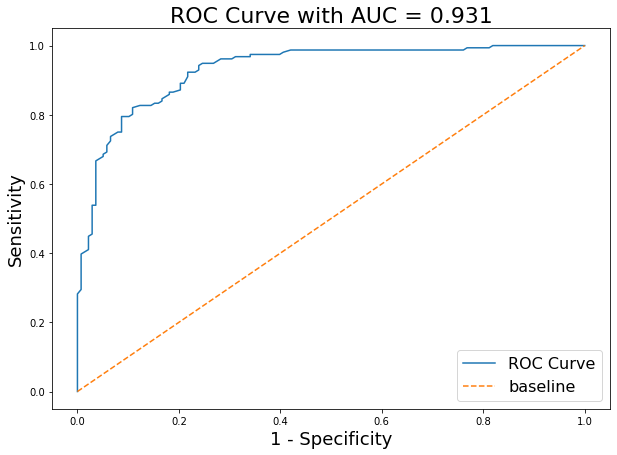

In [83]:
# Generate ROC Curve with AUC score
pipe_tv_nb_s.gen_roc_auc()

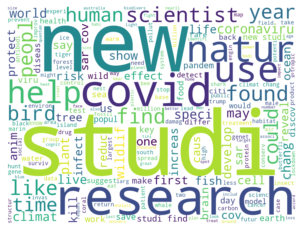

In [84]:
# Generate WordCloud
pipe_tv_nb_s.gen_wordcloud()

In [85]:
# Get top and lowest 5 features that affects prediction for Y = 1
pipe_tv_nb_s.get_nb_features()

Top 5 words for Y = 1
      features  Log Probability
2317     studi        -5.651337
546      covid        -5.745953
2008  research        -5.843689
1618       new        -5.969988
2552       use        -6.024373

Lowest 5 words for Y = 1
     features  Log Probability
0     abandon        -8.540856
1132     hike        -8.540856
1133    hippo        -8.540856
1147   hornet        -8.540856
1148     hors        -8.540856


In [86]:
# Add results to results DataFrame
pipe_tv_nb_s.add_to_results(df_results, 'stem')

## Model Evaluation and Selection

In [87]:
# Display tabulated results of all models
df_results

,Pre_processing,Transformer,Model,ROC_AUC_score,Train_data_score,Test_data_score,Score_change,Accuracy,Sensitivity,Specificity,Precision
0,lemma,cvec,logr,0.906,0.9898,0.8265,-0.1633,0.83,0.83,0.83,0.84
1,lemma,cvec,nb,0.925,0.9648,0.8401,-0.1247,0.84,0.88,0.79,0.83
2,lemma,tvec,logr,0.902,1.0000,0.8163,-0.1837,0.82,0.87,0.76,0.80
3,lemma,tvec,nb,0.924,0.9716,0.8639,-0.1077,0.86,0.90,0.83,0.85
4,stem,cvec,logr,0.902,1.0000,0.8095,-0.1905,0.81,0.82,0.80,0.82
5,stem,cvec,nb,0.931,0.9580,0.8401,-0.1179,0.84,0.90,0.77,0.82
6,stem,tvec,logr,0.916,0.9977,0.8401,-0.1576,0.84,0.92,0.75,0.81
7,stem,tvec,nb,0.931,0.9773,0.8537,-0.1236,0.85,0.92,0.78,0.83


In [108]:
df_results[['Pre_processing','Transformer','Model','ROC_AUC_score', 'Score_change','Accuracy']]

,Pre_processing,Transformer,Model,ROC_AUC_score,Score_change,Accuracy
0,lemma,cvec,logr,0.906,-0.1633,0.83
1,lemma,cvec,nb,0.925,-0.1247,0.84
2,lemma,tvec,logr,0.902,-0.1837,0.82
3,lemma,tvec,nb,0.924,-0.1077,0.86
4,stem,cvec,logr,0.902,-0.1905,0.81
5,stem,cvec,nb,0.931,-0.1179,0.84
6,stem,tvec,logr,0.916,-0.1576,0.84
7,stem,tvec,nb,0.931,-0.1236,0.85


---
For this problem, there are no negative implications for either a false postive or a false negative results.
Therefore, we will use Accuracy as one of the main metrics to consider.

Based on the tabulated data, the following observations can be made.

Regardless of the combination of preprocessing method, transformer or model, they share the similar characteristics of

- Accuracy in the range of 0.8
- High train data score of being close to 1, which suggests a higher degree of overfitting
- High ROC AUC score of >0.9, which indicates a good separation of the positive and negative populations, and consequently similar curves

Since the objective is to be able to correctly classify posts, it is important that our selected model is still able to perform on unseen data. Therefore, an important metric is the change in score when comparing testing the model on training data against testing data.

With the above considerations, the best model is the `lemma\tvec\nb` model. As described earlier, the models show similar levels of performance. In that case, choosing lemmatised words over stemmed words will give us words which are more meaningful. The main reason to choose TF-IDF Vectorizer with Naive Bayes MultinomialNB is due to the smallest change in score when scoring the model on testing data. It also scores the best in terms of accuracy.

In [88]:
pipe_tv_nb_l.get_nb_features()

Top 5 words for Y = 1
        features  Log Probability
1693       study        -5.321794
443        covid        -5.437965
1175         new        -5.649251
1451  researcher        -5.795912
1277      people        -5.861720

Lowest 5 words for Y = 1
       features  Log Probability
0     abandoned         -8.33192
1575     shrimp         -8.33192
392    conflict         -8.33192
1581   sighting         -8.33192
1601        sky         -8.33192


The top 5 features are 1) study 2) covid 3) new 4) researcher 5) people.

## Test Selected Model on Unseen Data

In [89]:
# Grab new data (4 pages) from the respective subreddits
# get_posts(url_list, 4, save_name='test')

In [90]:
# Read test csv
df_test = pd.read_csv('./datasets/test.csv')

In [91]:
# Fill null entries with ''
df_test.fillna('', inplace=True)

In [92]:
# Check for duplicates
df_test.duplicated(subset=['name']).value_counts()

False    200
dtype: int64

In [93]:
# Create new column which combines both title and selftext
df_test['post'] = df_test['title'] + ' ' + df_test['selftext']

In [94]:
# Remove extra columns
df_test.drop(columns=['name','title','selftext'], axis=1, inplace=True)

In [95]:
# Encode subreddit column
df_test['subreddit'] = df_test['subreddit'].map({subreddit_1:1, subreddit_2:0})

In [96]:
df_test.head()

,subreddit,post
0,1,U.S. adults look to scientific organizations l...
1,1,Blind people who were sighted before becoming ...
2,1,Shrinking Ice Sheets Lifted Global Sea Level 1...
3,1,Chest X-rays performed on young &amp; middle-a...
4,1,Quantum Entanglement of 15 Trillion Atoms at 4...


In [97]:
df_test.shape

(200, 2)

In [98]:
# Run function that preprocess and lemmatize posts
for i in range(len(df_test['post'])):
    df_test.iloc[i,1] = clean_postl(df_test.iloc[i,1])

In [99]:
df_test.head()

,subreddit,post
0,1,u adult look scientific organization like cent...
1,1,blind people sighted becoming blind could see ...
2,1,shrinking ice sheet lifted global sea level mi...
3,1,chest x ray performed young middle aged adult ...
4,1,quantum entanglement trillion atom kelvin surp...


In [100]:
# Define X and y
X_unseen = df_test['post']
y_unseen = df_test['subreddit']

In [101]:
# Score selected model on unseen data
pipe_tv_nb_l.pipe_GS.best_estimator_.score(X_unseen,y_unseen)

0.86

**Comment**

The model is able to hold up when tested on newly extracted posts.

## Conclusion and Recommendations

Through this exercise, we have determined that the best classification model that is able to achieve 80% accuracy is the  Lemmatization -> TF-IDF Vectorizer -> Naive Bayes MultinomialNB model. 

The top 5 features are 1) study 2) covid 3) new 4) researcher 5) people.

However, in view of the fact that one of the top features is `covid`, it is apparent that the model is picking up certain time-sensitive terms. These terms are likely to be irrelevant over time. Therefore, to stabilise the performance of the model, it is reccommended to build up the training data over a period of time and reinforce the model.

Secondly, the models have a high tendency to overfit the train data from the train_test_split. Though we have selected the model with the least drop in score when testing it on test data, the drop is still rather significant. Therefore, when searching through parameters for the best model using GridSearch, it might be preferable to search for the best model using the least drop in score, rather than the current highest score.